In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from sklearn.model_selection import train_test_split

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [133]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../HSG Historical Data.csv')

In [134]:
# convert date field from string to Date format and make it index
def tranformData(df: pd.DataFrame):
  df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
  df['Price'] = df['Price'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Open'] = df['Open'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['High'] = df['High'].astype(str).apply(lambda x: float(x.replace(',', '')))
  df['Low'] = df['Low'].astype(str).apply(lambda x: float(x.replace(',', '')))
  def convert_to_number(x):
      if 'M' in x:
          return float(x.replace('M', '')) * 1000000
      elif 'K' in x:
          return float(x.replace('K', '')) * 1000
      else:
          return float(x)
  df['Vol.'] = df['Vol.'].apply(convert_to_number)
  df['Change %'] = df['Change %'].apply(lambda x: float(x.strip('%'))/100)

In [135]:
tranformData(df)

In [136]:
#Định dạng lại cột Date từ obj -> datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
# Chuyển cột Date làm index để lập biểu đồ so sánh về sau
df.index = df.Date
df.drop('Date', axis=1, inplace=True)

In [137]:
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,13830.5,13772.9,13917.0,13657.6,4410000.0,0.0084
2017-12-04,14781.4,14061.0,14781.4,13830.5,13710000.0,0.0688
2017-12-05,14522.1,15040.7,15242.4,14522.1,12280000.0,-0.0175
2017-12-06,14896.6,14464.4,15069.5,14320.4,9470000.0,0.0258
2017-12-07,14666.1,15098.3,15184.8,14550.9,5520000.0,-0.0155
...,...,...,...,...,...,...
2023-05-29,15700.0,15500.0,15700.0,15350.0,9600000.0,0.0228
2023-05-30,15850.0,15800.0,16000.0,15600.0,13350000.0,0.0096
2023-05-31,15400.0,15800.0,15850.0,15200.0,36230000.0,-0.0284


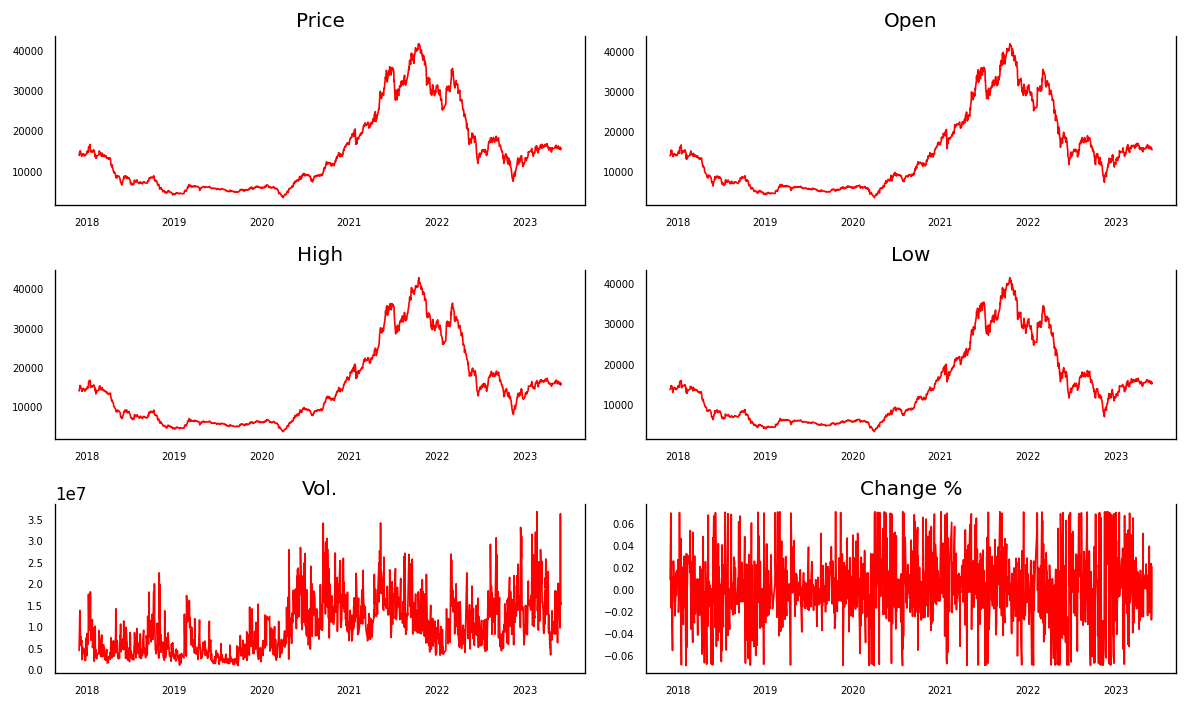

In [138]:


# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();
     

In [139]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)  

,Price_x,Open_x,High_x,Low_x,Vol._x,Change %_x
Price_y,1.0000,0.0001,0.0006,0.0000,0.0002,0.0128
Open_y,0.0000,1.0000,0.0000,0.0000,0.0001,0.0000
High_y,0.0000,0.0000,1.0000,0.0000,0.0012,0.0000
Low_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
Vol._y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
Change %_y,0.1397,0.3697,0.0382,0.3542,0.0077,1.0000


In [140]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  689.47    > 83.9383   =>   True
Open   ::  457.21    > 60.0627   =>   True
High   ::  249.81    > 40.1749   =>   True
Low    ::  94.7      > 24.2761   =>   True
Vol.   ::  26.96     > 12.3212   =>   True
Change % ::  0.37      > 4.1296    =>   False


In [141]:
nobs=int(0.2*len(df))
n_train = int(0.7 * len(df))
n_test = int(0.2 * len(df))
n_validation = len(df) - n_train - n_test
nobs_val= n_validation
df_train = df[:n_train]
df_test = df[n_train:n_train+n_test]
df_validation = df[n_train+n_test:]

# Kiểm tra kích thước
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)

(959, 6)
(274, 6)
(138, 6)


In [142]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [143]:
# ADF Test on each column
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.9935
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.9987. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.9885
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.9987. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [144]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [145]:
# ADF Test trên từng cột của DataFrame chứa sự khác biệt đầu tiên
for name in df_differenced.columns:
    adfuller_test(df_differenced[name], name=name)
    print('\n')


    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.6117
 No. Lags Chosen       = 20
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7175
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    =

In [146]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [147]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.8878
 No. Lags Chosen       = 22
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.2414
 No. Lags Chosen       = 21
 Critical value 1%     = -3.437
 Critical value 5%     = -2.865
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 

In [148]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  70.26482570679421
BIC :  70.47846151468977
FPE :  3.278134423681738e+30
HQIC:  70.3461993351241 

Lag Order = 2
AIC :  68.53190394333305
BIC :  68.92898612611577
FPE :  5.794715244028436e+29
HQIC:  68.6831597264098 

Lag Order = 3
AIC :  67.56648835121996
BIC :  68.14732237485214
FPE :  2.2068193287144558e+29
HQIC:  67.78774972809015 

Lag Order = 4
AIC :  66.88574378382934
BIC :  67.65063595124604
FPE :  1.117225441619182e+29
HQIC:  67.17713454049309 

Lag Order = 5
AIC :  66.33273301741839
BIC :  67.28199047169485
FPE :  6.4268762687548415e+28
HQIC:  66.69437728816091 

Lag Order = 6
AIC :  66.04519362005755
BIC :  67.17912434759181
FPE :  4.8213154336653205e+28
HQIC:  66.47721588878711 

Lag Order = 7
AIC :  65.748523735833
BIC :  67.06743656954396
FPE :  3.584118366172379e+28
HQIC:  66.25104883742544 

Lag Order = 8
AIC :  65.50509340453584
BIC :  67.00929802707675
FPE :  2.8102186736490985e+28
HQIC:  66.07824652618561 

Lag Order = 9
AIC :  65.2750285790856
BI

In [149]:
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,74.18,74.21,1.648e+32,74.19
1,70.29,70.50,3.349e+30,70.37
2,68.55,68.95,5.879e+29,68.70
3,67.58,68.16,2.232e+29,67.80
4,66.89,67.66,1.124e+29,67.18
5,66.34,67.30,6.499e+28,66.71
6,66.06,67.19,4.871e+28,66.49
7,65.76,67.08,3.618e+28,66.26
8,65.51,67.02,2.830e+28,66.09
9,65.28,66.97*,2.243e+28,65.92


In [150]:
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 17, Jun, 2023
Time:                     00:20:39
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    70.4785
Nobs:                     956.000    HQIC:                   70.3462
Log likelihood:          -41683.6    FPE:                3.27813e+30
AIC:                      70.2648    Det(Omega_mle):     3.13774e+30
--------------------------------------------------------------------
Results for equation Price
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.184787        16.529201           -0.011           0.991
L1.Price           -0.572512         0.052480          -10.909           0.000
L1.Open            -0.206754         0.050057           -4.130      

In [151]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

1


array([[ 1.0834e+03, -1.5834e+03,  1.6670e+02, -5.8330e+02,  2.1200e+06,
         8.3900e-02]])

In [152]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[n_train:n_train+n_test], columns=df.columns + '_2d')
df_forecast

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2021-10-07,-338.089755,1589.276850,335.854888,842.337498,-428918.120007,-0.057555
2021-10-08,-90.491194,-873.354198,-279.509632,-545.048504,-654560.391220,0.006974
2021-10-11,187.876847,235.874638,70.848465,184.278635,844929.551041,0.020863
2021-10-12,-121.302559,68.752162,69.542329,25.287133,-603136.838791,-0.023385
2021-10-13,33.057830,-114.042095,-104.898545,-78.959905,274789.758347,0.014062
...,...,...,...,...,...,...
2022-11-03,-0.098438,0.119849,-0.219099,0.245774,-6799.038119,-0.000004
2022-11-04,-0.098438,0.119849,-0.219099,0.245774,-6799.038119,-0.000004
2022-11-07,-0.098438,0.119849,-0.219099,0.245774,-6799.038119,-0.000004


In [153]:
# Forecast val
fc_val = model_fitted.forecast(y=forecast_input, steps=nobs_val)
df_forecast_val = pd.DataFrame(fc_val, index=df.index[n_train+n_test:], columns=df.columns + '_2d')
df_forecast_val

,Price_2d,Open_2d,High_2d,Low_2d,Vol._2d,Change %_2d
Date,,,,,,
2022-11-10,-338.089755,1589.276850,335.854888,842.337498,-428918.120007,-0.057555
2022-11-11,-90.491194,-873.354198,-279.509632,-545.048504,-654560.391220,0.006974
2022-11-14,187.876847,235.874638,70.848465,184.278635,844929.551041,0.020863
2022-11-15,-121.302559,68.752162,69.542329,25.287133,-603136.838791,-0.023385
2022-11-16,33.057830,-114.042095,-104.898545,-78.959905,274789.758347,0.014062
...,...,...,...,...,...,...
2023-05-29,-0.098438,0.119849,-0.219099,0.245774,-6799.038119,-0.000004
2023-05-30,-0.098438,0.119849,-0.219099,0.245774,-6799.038119,-0.000004
2023-05-31,-0.098438,0.119849,-0.219099,0.245774,-6799.038119,-0.000004


In [154]:
def invert_transformation(df_train, df_forecast_val, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc_val = df_forecast_val.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc_val[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc_val[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc_val[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc_val[str(col)+'_1d'].cumsum()
    return df_fc_val

In [155]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [156]:
df_results_val = invert_transformation(df_train, df_forecast_val, second_diff=True)        
df_results_val.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2022-11-10,40370.310245,41047.576850,41002.554888,40717.337498,5.351082e+06,-0.020155
2022-11-11,40358.429295,41221.799502,41100.600144,41014.626493,1.057603e+06,-0.043835
2022-11-14,40534.425193,41631.896793,41269.493864,41496.194123,-2.390946e+06,-0.046652
2022-11-15,40589.118531,42110.746245,41507.929914,42003.048885,-6.442631e+06,-0.072855
2022-11-16,40676.869699,42475.553602,41641.467418,42430.943743,-1.021953e+07,-0.084995
...,...,...,...,...,...,...
2023-05-29,51404.140400,96539.276550,63449.803127,104612.247728,-5.639103e+08,-2.222647
2023-05-30,51480.847731,96966.067615,63604.465707,105110.141792,-5.686443e+08,-2.239463
2023-05-31,51557.456623,97392.978529,63758.909188,105608.281630,-5.733851e+08,-2.256283


In [157]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]

,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
Date,,,,,,
2021-10-07,40370.310245,41047.576850,41002.554888,40717.337498,5.351082e+06,-0.020155
2021-10-08,40358.429295,41221.799502,41100.600144,41014.626493,1.057603e+06,-0.043835
2021-10-11,40534.425193,41631.896793,41269.493864,41496.194123,-2.390946e+06,-0.046652
2021-10-12,40589.118531,42110.746245,41507.929914,42003.048885,-6.442631e+06,-0.072855
2021-10-13,40676.869699,42475.553602,41641.467418,42430.943743,-1.021953e+07,-0.084995
...,...,...,...,...,...,...
2022-11-03,60932.677137,155683.076822,82472.586908,174582.045984,-1.270151e+09,-4.545151
2022-11-04,60995.996909,156126.167375,82597.452050,175113.365316,-1.275810e+09,-4.562493
2022-11-07,61059.218243,156569.377777,82722.098092,175644.930421,-1.281475e+09,-4.579839


In [158]:
# Chuyển đổi dự đoán về đơn vị ban đầu
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to the original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col) + '_1d'] = (df_train[col].iloc[-1] - df_train[col].iloc[-2]) + df_fc[col + '_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col) + '_forecast'] = df_train[col].iloc[-1] + df_fc[col + '_1d'].cumsum()
    return df_fc

df_future_results = invert_transformation(df_train, df_future, second_diff=True)
df_future_results.loc[:, ['Price_forecast', 'Open_forecast', 'High_forecast', 'Low_forecast',
                   'Vol._forecast', 'Change %_forecast']]


,Price_forecast,Open_forecast,High_forecast,Low_forecast,Vol._forecast,Change %_forecast
0,40370.310245,41047.576850,41002.554888,40717.337498,5.351082e+06,-0.020155
1,40358.429295,41221.799502,41100.600144,41014.626493,1.057603e+06,-0.043835
2,40534.425193,41631.896793,41269.493864,41496.194123,-2.390946e+06,-0.046652
3,40589.118531,42110.746245,41507.929914,42003.048885,-6.442631e+06,-0.072855
4,40676.869699,42475.553602,41641.467418,42430.943743,-1.021953e+07,-0.084995
...,...,...,...,...,...,...
269,60932.677137,155683.076822,82472.586908,174582.045984,-1.270151e+09,-4.545151
270,60995.996909,156126.167375,82597.452050,175113.365316,-1.275810e+09,-4.562493
271,61059.218243,156569.377777,82722.098092,175644.930421,-1.281475e+09,-4.579839
272,61122.341138,157012.708028,82846.525036,176176.741301,-1.287147e+09,-4.597189


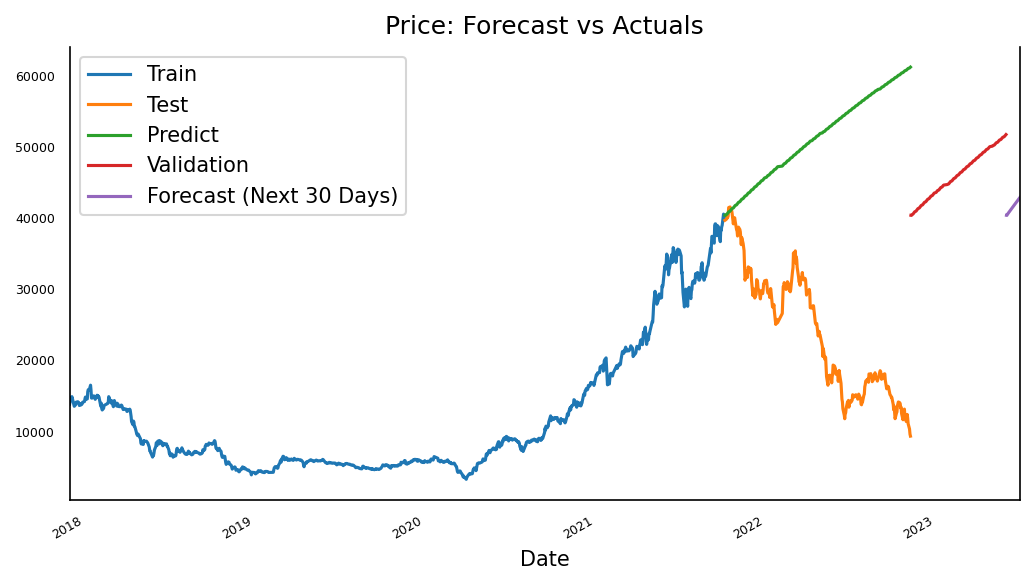

In [159]:
import datetime

# Sử dụng model_fitted để dự đoán 30 ngày tiếp theo
n_forecast_days = 30
fc = model_fitted.forecast(y=forecast_input, steps=n_forecast_days)

# Chuyển đổi dự đoán thành DataFrame
df_future = pd.DataFrame(fc, columns=[col + '_2d' for col in df.columns])

# Chuyển đổi dự đoán về đơn vị ban đầu
df_future_results = invert_transformation(df_train, df_future, second_diff=True)

# Tạo index cho 30 ngày tiếp theo
future_dates = pd.date_range(start=df.index[-1] + datetime.timedelta(days=1), periods=n_forecast_days, freq='D')

# Tạo DataFrame chứa dự đoán cho 30 ngày tiếp theo
df_future_forecast = pd.DataFrame(df_future_results.values, index=future_dates, columns=df_future_results.columns)

# Vẽ đồ thị
fig, ax = plt.subplots(dpi=150, figsize=(7, 4))

# Chọn cột dữ liệu cần vẽ
col = 'Price'

# Vẽ dữ liệu huấn luyện
df_train[col].plot(legend=True, ax=ax, label='Train')

# Vẽ dữ liệu kiểm tra
df_test[col][-nobs:].plot(legend=True, ax=ax, label='Test')

# Vẽ dự đoán trên tập huấn luyện
df_results[col+'_forecast'].plot(legend=True, ax=ax, label='Predict').autoscale(axis='x', tight=True)

# Vẽ dự đoán trên tập kiểm tra
df_results_val[col+'_forecast'].plot(legend=True, ax=ax, label='Validation').autoscale(axis='x', tight=True)

# Vẽ dự đoán cho 30 ngày tiếp theo
df_future_forecast[col + '_forecast'].plot(legend=True, ax=ax, label='Forecast (Next 30 Days)')

# Định dạng đồ thị và tiêu đề
ax.set_title(col + ": Forecast vs Actuals")
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
ax.spines["top"].set_alpha(0)
ax.tick_params(labelsize=6)

plt.tight_layout()


In [160]:
def forecast_accuracy(forecast, actual):
    forecast = np.array(forecast)  # Chuyển đổi dự đoán thành numpy array
    actual = np.array(actual)  # Chuyển đổi dữ liệu thực tế thành numpy array
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return {'mape': mape, 'rmse': rmse, }


print('Forecast Accuracy of: Price')
accuracy_prod = forecast_accuracy(df_results['Price_forecast'].values, df_test['Price'])
for k, v in accuracy_prod.items():
    print(str.title(k), ': ', round(v, 4))



Forecast Accuracy of: Price
Mape :  1.5929
Rmse :  31131.7911
